In [35]:
import os

from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import (
    Simulator,
    StartMeshcat,
)

from manipulation import FindResource, running_as_notebook
from manipulation.scenarios import AddMultibodyTriad
from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario

import os
import numpy as np
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.robot.test_direct_joint_control import (
    TestDirectJointControl,
)
from manipulation.station import MakeHardwareStation, load_scenario

import numpy as np
from pydrake.all import (
    AbstractValue,
    ConstantVectorSource,
    DiagramBuilder,
    LeafSystem,
    PiecewisePose,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.pick.test_robot_painter import TestRobotPainter
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import AddIiwaDifferentialIK
from manipulation.station import MakeHardwareStation, load_scenario


from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    FindResourceOrThrow,
    Parser,
    RandomGenerator,
    SceneGraph,
    RigidTransform,
    Role,
    RollPitchYaw,
    Simulator,
    UniformlyRandomRotationMatrix,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
    RenderCameraCore,
    DepthRenderCamera,
    PointCloud,
    BaseField,
    Fields,
)

from pydrake.all import (
    AbstractValue, Adder, AddMultibodyPlantSceneGraph, BallRpyJoint, BaseField,
    Box, CameraInfo, ClippingRange,
    DepthImageToPointCloud, DepthRange, DepthRenderCamera, DiagramBuilder,
    FindResourceOrThrow,
    LeafSystem,
    MakeRenderEngineVtk, ModelInstanceIndex, Parser, RenderCameraCore,
    RenderEngineVtkParams, RgbdSensor, RigidTransform,
    RollPitchYaw, Role,
    ImageRgba8U, ImageDepth32F)

from manipulation.station import (
    AddPointClouds,
    MakeHardwareStation,
    load_scenario,
)

In [46]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [ ]:
# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">

  <model name="table_top">
    <link name="table_top_link">
      <inertial>
        <mass>18.70</mass>
        <inertia>
          <ixx>0.79</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.53</iyy>
          <iyz>0</iyz>
          <izz>1.2</izz>
        </inertia>
      </inertial>
    <visual name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.49 0.63 0.015</size>
          </box>
        </geometry>
        <material>
          <diffuse>0.9 0.9 0.9 1.0</diffuse>
        </material>
      </visual>
      <collision name="bottom">
        <pose>0.0 0.0 0.445 0 0 0</pose>
        <geometry>
          <box>
            <size>0.49 0.63 0.015</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1.0e6</drake:hydroelastic_modulus>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

In [ ]:
table_top_sdf_file

'/tmp/robotlocomotion_drake_xM72G8/table_top.sdf'

# Adding Models 

In this exercise, you will learn the basics of adding objects into Drake. You will learn about URDFs, SDFs, and obj files. 

Parts of this notebook were taken from the [Authoring a Multibody Simulation tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/authoring_multibody_simulation-add293478aac40a984845aa3705eefdd?). Still, it is useful to take a look at the tutorial to learn more about the concepts.

A high level overview of the different formats around describing simulations in Drake:
- URDF and SDF are XML formats that can specify the kinematic and dynamic properties of robots or objects. SDF is the more scalable format, and it is the format that is recommended. However, they should be mostly interchangeable with small syntax differences.
- .obj on the other hand, is a file format that describes the *geometry* of an object, such as a mesh of the surface of the object.
  - There exist other geometry formats, such as .stl, and .dae. These are not well-supported by Drake directly, but [Meshlab](https://www.meshlab.net/), an open-source software, is a handy tool to convert common formats to a `.obj` for you.
- [Model directives](https://drake.mit.edu/doxygen_cxx/structdrake_1_1multibody_1_1parsing_1_1_model_directive.html) are a YAML specification that makes it easy to load multiple URDF and SDF objects into a simulation. They're used at the bottom of this notebook.


The most important formats for creating multibody scenarios in Drake are the [Unified Robot Description Format (URDF)](http://wiki.ros.org/urdf) and the [Simulation Description Format (SDFormat)](http://sdformat.org/).

They are both XML formats to describe robots or objects for robot simulators or visualization, and are fairly similar in syntax.

In a high-level sense, you express different components of your robot using `<link>` tags and connect them via `<joint>` tags. Each `<link>` has three major subtags, `<visual>`, `<collision>`, and `<inertial>`, for its visualization, planning/collision checking, and dynamics aspects. For `<visual>` and `<collision>`, you can either use primitives (box, sphere, cylinder, etc.) or meshes (.obj) to represent the underlying geometry.

The supported primitive types and the supported file types for meshes are described [here](https://drake.mit.edu/doxygen_cxx/group__geometry__file__formats.html). 

### Written Question
Compare and contrast two SDF files of the same YCB sugar box: [File 1](https://github.com/RobotLocomotion/drake/blob/8ed3a0264c521ffc1ea8861f5701b81dfb696af8/manipulation/models/ycb/sdf/004_sugar_box.sdf) and [File 2](https://github.com/RussTedrake/manipulation/blob/24f122591f72cc78931ea3f461d0c34845dc9aca/manipulation/models/hydro/004_sugar_box.sdf). File 2 uses hydroelastic contact, and file 1 uses the default point contact model.

[Hydroelastic contact](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html) in Drake can be used to create compliant collision geometries. This is a great tool for improving the contact dynamics between simulated objects, compared to traditional rigid contact geometries.

Answer the following questions in your written submission.

**Part (a):**  How is the collision geometry (not contact models!) different in File 1 than File 2? What tags enable hydroelastic contact in File 2?

**Part (b):**  In both files, we use the sugar box obj mesh as the visual geometry. For File 2, we could have used the obj mesh as the collision geometry too. In one sentence, why might we prefer to specify the collision geometry using primitives, rather than using the obj mesh? 

## Adding your own models

Now, you will add an object of your choosing into simulation! You have a lot of freedom here. Ideally, this object can be used in your final project. It doesn't have to be an object your robot can pick up; it can be anything you want in your simulation. 

- The only requirement is it cannot be directly taken from the existing models in Drake without modification.
- Your model file can be in any of the formats supported by the [Parser](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_parser.html), but we recommend using SDF. Your model should use hydroelastic contact.

One option is to find a 3D model online, such as at [TurboSquid](https://www.turbosquid.com/3d-model/free), and convert it into a .obj file. The .obj file can then be directly turned into a SDF file by using the below terminal command, documented [here](https://drake.mit.edu/pydrake/pydrake.multibody.mesh_to_model.html). On Deepnote, you can open a terminal on the left bar and run the command after you have uploaded your .obj file. 
```sh
python3 -m pydrake.multibody.mesh_to_model path/to/mesh.obj
```
We have a more advanced version of this tool available in `manipulation/create_sdf_from_mesh.py`, which additionally supports convex decomposition of a nonconvex mesh and mesh simplification. This isn't needed for this problem, but may be very useful for your project.

Another option is to purely use SDF and geometric primitives to compose primitives (and maybe meshes) to build up your object. 

Here's some more examples of various SDF files to use as inspiration or a guide: 
- [Rubik's Cube](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/02-Lets-get-you-a-robot-8f86172b-b597-4ceb-9bad-92d11ac7a6cc/notebook/rubiks_cube-35164353b13d4a47910ca14e588c74d6?)
- [Drake examples](https://github.com/RobotLocomotion/drake/tree/master/examples), which includes things such as a bouncing ball. 
- If there was a [final project](https://manipulation.csail.mit.edu/misc.html#projects) that had objects you'd like to use, see if their code is open source or ask!

Once you have created your model file, fill in the **absolute path** below. On Deepnote, there is an option on the left bar to copy paths into your clipboard. 

**Part (c):** In your written submission, briefly describe what your object is. Take a screenshot of your object on the table in simulation (the final code cell). Your screenshot should include red contact force arrows and not green contact force arrows, which indicate that you are using hydroelastic contact. 

In [ ]:
cwd = os.getcwd()
your_model_filename = cwd+"/Board.sdf" # Write the absolute path to your file here


It is very helpful to visualize and check your model prior to putting it into simulation. Run the below cell to do so. 

Under the `Scene > drake` dropdown in MeshCat, you can enable viewing 'illustration', 'inertia', and 'proximity' to see the visual model, inertia matrix, and collision model, respectively. You can also adjust the poses of the links in the sliders. 

In [91]:
def convert_to_coords(pos):
    x = ord(pos[0]) - ord('a')
    y = int(pos[1])-1
    return "" + str(.6*.125*(y-3.5)) + ", "+ str(.6*.125*(x-3.5)) 

def get_starting_pose(pos):
    # They are flipped buy oh well
    x = ord(pos[0]) - ord('a')
    y = int(pos[1])-1
    return RigidTransform([.6*.125*(y-3.5), .6*.125*(x-3.5), 0])

def add_piece(piece_id, name,  pos):
    return f"""
- add_model:
    name: {piece_id}
    file: file://{cwd}/{name}.sdf
    default_free_body_pose:
        {name}:
            translation: [{convert_to_coords(pos)}, .75]
            rotation: !Rpy {{ deg: [0, 0, 0] }}"""


Now, we'll create the simulation with your model. The simulation is replayable in MeshCat. A YCB sugar box has been added to the simulation as a reference, but you may comment it out and remove it.

You will have to replace the link specified in the model directives based on your file. You may have to adjust the starting pose of your model, physical properties of your model, and/or the size of the table (defined at the top of the file) in order to not have your object fall through the world.

In [102]:
scenario = None
def create_scene():
    global scenario
    scenario_data = f"""
directives:
- add_model:
    name: table_top
    file: file://{table_top_sdf_file}
- add_weld:
    parent: world
    child: table_top::table_top_center
"""
    if your_model_filename:
        scenario_data += f"""
- add_model:
    name: board
    file: file://{your_model_filename}
    default_free_body_pose:
        Board:
            translation: [0, 0, .5]
            rotation: !Rpy {{ deg: [90, 0, 0] }}    
"""
    scenario_data += add_piece('p1', 'BlackKnight',  'b8')
    scenario_data += add_piece('p2', 'BlackBishop',  'c8')
    scenario_data += add_piece('p3', 'BlackKnight',  'g8')
    scenario_data += add_piece('p4', 'BlackBishop',  'f8')
    scenario_data += add_piece('p5', 'BlackQueen',  'd8')
    scenario_data += add_piece('p6', 'BlackRook',  'a8')
    scenario_data += add_piece('p7', 'BlackRook',  'h8')
    scenario_data += add_piece('p8', 'BlackKing',  'e8') 
    scenario_data += add_piece('p9', 'WhiteKnight',  'b1')
    scenario_data += add_piece('p10', 'WhiteBishop',  'c1')
    scenario_data += add_piece('p11', 'WhiteKnight',  'g1')
    scenario_data += add_piece('p12', 'WhiteBishop',  'f1')
    scenario_data += add_piece('p13', 'WhiteQueen',  'd1')
    scenario_data += add_piece('p14', 'WhiteRook',  'a1')
    scenario_data += add_piece('p15', 'WhiteRook',  'h1')
    scenario_data += add_piece('p16', 'WhiteKing',  'e1')
    for i in range(8): 
       scenario_data += add_piece(f"p{17+i}", 'WhitePawn',  f"{chr(97+i)}2")
       scenario_data += add_piece(f"p{25+i}", 'BlackPawn',  f"{chr(97+i)}7")
    
    scenario_data += """
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
    X_PC:
        translation: [0, .55, 0]

- add_model:
    name: gripper
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf
- add_weld:
    parent: iiwa_link_7
    child: gripper::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 0] }
- add_model:
    name: camera
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: gripper::body
    child: camera::base
    X_PC:
        translation: [-0.4, 0, -0.4]
        # Point slightly down towards camera
        # RollPitchYaw(0, -0.2, 0.2) @ RollPitchYaw(-np.pi/2, 0, np.pi/2)
        rotation: !Rpy { deg: [45, 0, 0] }
model_drivers:
    iiwa: !IiwaDriver
        hand_model_name: gripper
    gripper: !SchunkWsgDriver {}
cameras:
    main_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera::base
"""
    with open('board.yaml', 'w') as f:
        f.write(scenario_data)
        
    scenario = load_scenario(data=scenario_data)
    station = MakeHardwareStation(scenario, meshcat)


    return station
    """simulator = Simulator(station)
    meshcat.StartRecording()
    simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
    meshcat.PublishRecording()"""


#create_scene()

In [103]:
class PoseTrajectorySource(LeafSystem):
    def __init__(self, pose_trajectory):
        LeafSystem.__init__(self)
        self._pose_trajectory = pose_trajectory
        self.DeclareAbstractOutputPort(
            "pose", lambda: AbstractValue.Make(RigidTransform()), self.CalcPose
        )

    def CalcPose(self, context, output):
        # HAS BEEN MODIFIED: OLD contents
        #
        #def CalcPose(self, context, output):
        #output.set_value(self._pose_trajectory.GetPose(context.get_time()))
        #
        
        output.set_value(self._pose_trajectory.GetPose(context.get_time()))

def buildAndRun(traj=None):
    global scenario
    builder = DiagramBuilder()
    hardware_station = create_scene()
    # plant, scene_graph = builder.AddMultibodyPlantSceneGraph(station.GetSubsystemByName("plant"), station.GetSubsystemByName("scene_graph"))
    station = builder.AddSystem(hardware_station)
    plant = station.GetSubsystemByName("plant")
    scene_graph = builder.AddSystem(SceneGraph())
    #plant.GetJointByName("iiwa_joint_7").set_position_limits([-np.inf], [np.inf])

    # NOTE: This takes photos along the +z axis
    # IIRC +90 in the x axis to take photos away from gripper
    controller_plant = station.GetSubsystemByName(
        "iiwa.controller"
    ).get_multibody_plant_for_control()
    builder.ExportOutput(
        station.GetOutputPort("camera0.rgb_image"), "rgb_image"
    )
    builder.ExportOutput(
        station.GetOutputPort("camera0.depth_image"), "depth_image"
    )
    to_point_cloud = AddPointClouds(
        scenario=scenario, station=station, builder=builder, meshcat=meshcat
    )

    # Add a box for the camera in the environment.
    plant = station.GetSubsystemByName("plant")
    camera_instance = plant.GetModelInstanceByName("camera")
    scene_graph = station.GetSubsystemByName("scene_graph")
    AddMultibodyTriad(
        plant.GetFrameByName("base", camera_instance),
        scene_graph,
        length=0.1,
        radius=0.005,
    )

    # # Export the point cloud output.
    builder.ExportOutput(
        to_point_cloud["camera0"].point_cloud_output_port(), "point_cloud"
    )

    #here is where the controller is added 
    if traj is not None:
        traj_source = builder.AddSystem(PoseTrajectorySource(traj))
        controller = AddIiwaDifferentialIK(
            builder,
            controller_plant,
            frame=controller_plant.GetFrameByName("body"),
        )
        builder.Connect(
            traj_source.get_output_port(),
            controller.get_input_port(0),
        )
        builder.Connect(
            station.GetOutputPort("iiwa.state_estimated"),
            controller.GetInputPort("robot_state"),
        )

        builder.Connect(
            controller.get_output_port(),
            station.GetInputPort("iiwa.position"),
        )

    wsg_position = builder.AddSystem(ConstantVectorSource([0.1]))
    builder.Connect(
        wsg_position.get_output_port(),
        station.GetInputPort("gripper.position"),
    )

    diagram = builder.Build()
    # gripper_frame = plant.GetFrameByName("gripper:body")
    world_frame = plant.world_frame()

    context = CreateDefaultContext(diagram, plant)

    diagram.ForcedPublish(context)

    return diagram, plant, station

def CreateDefaultContext(diagram, plant):
    context = diagram.CreateDefaultContext()
    plant_context = diagram.GetMutableSubsystemContext(
        plant, context
    )

    # provide initial states
    q0 = np.array(
        [
            1.40666193e-05,
            1.56461165e-01,
            -3.82761069e-05,
            -1.32296976e00,
            -6.29097287e-06,
            1.61181157e00,
            -2.66900985e-05,
        ]
    )
    # set the joint positions of the kuka arm
    iiwa = plant.GetModelInstanceByName("iiwa")
    plant.SetPositions(plant_context, iiwa, q0)
    plant.SetVelocities(plant_context, iiwa, np.zeros(7))
    gripper = plant.GetModelInstanceByName("gripper")
    plant.SetPositions(plant_context, gripper, [-0.05, 0.05])
    plant.SetVelocities(plant_context, gripper, [0, 0])

    return context




In [104]:
# TRAJ USED TO BE A traj = PiecewisePose.MakeLinear(times, key_frame_poses)
# FIX THIS.
start = RigidTransform([0,0,0])
base = get_starting_pose('d4')
top = RigidTransform([0,0,0.1])
num_key_frames = 1
times = np.linspace(0, 20, num_key_frames + 1)
key_frame_poses = [start, base@top]
traj = PiecewisePose.MakeLinear(times, key_frame_poses)
diagram, plant, station = buildAndRun(traj)

context = CreateDefaultContext(diagram, plant)
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

duration = 2.0 if running_as_notebook else 0.01
simulator.AdvanceTo(duration)

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x564d13a576a0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x564d13a576a0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x564d13a576a0): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x564d13a576a0): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x564d17918040): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 272
vtkPNGReader (0x564d17918040): Invalid file header: not a PNG file

ERROR: In vtkPNGReader.cxx, line 133
vtkPNGReader (0x564d17918040): Unknown file type! Not a PNG file!

ERROR: In vtkPNGReader.cxx, line 396
vtkPNGReader (0x564d17918040): Invalid file header: not a PNG file

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due t

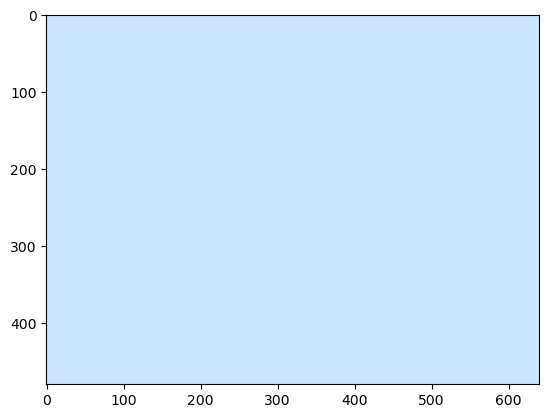

In [89]:
context = CreateDefaultContext(diagram, plant)

# station = diagram.GetSubsystemByName("station")
import matplotlib.pyplot as plt
img = diagram.GetOutputPort('rgb_image').Eval(context).data
# plt.plot(img)
plt.imshow(img)

In [90]:
img = diagram.GetOutputPort('point_cloud').Eval(context)


In [86]:
dir(img)

['C',
 'Crop',
 'D',
 'EstimateNormals',
 'FlipNormalsTowardPoint',
 'IsDefaultValue',
 'IsInvalidValue',
 'SetFields',
 'SetFrom',
 'T',
 'VoxelizedDownSample',
 '__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_pybind11_del_orig',
 'fields',
 'has_normals',
 'has_rgbs',
 'has_xyzs',
 'kDefaultValue',
 'mutable_normal',
 'mutable_normals',
 'mutable_rgb',
 'mutable_rgbs',
 'mutable_xyz',
 'mutable_xyzs',
 'normal',
 'normals',
 'resize',
 'rgb',
 'rgbs',
 'size',
 'xyz',
 'xyzs']

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

This notebook only consists of written questions, so please submit all responses in your PDF submission to Gradescope. For this exercise, you should have completed the following subparts:
- Correct answers to part (a)
- Correct answers to part (b)
- A screenshot and description of your added object for part (c)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8432d35-2370-4de9-924c-af3802cf315d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>